<br>
<br>

![iteso](https://upload.wikimedia.org/wikipedia/en/5/5f/Western_Institute_of_Technology_and_Higher_Education_logo.png)

**InstitutoTecnológico y de Estudios Superiores de Occidente**
<br />
<br />
**Maestría Ciencia de Datos**
# Proyecto de limpieza de datos: Ingeniería de Características

<br>
<br>

* * *

Estudiante: Daniel Nuño <br>
Profesor: Dr. Carlos Augusto Arellano Muro <br>
Fecha entrega: 10 de mayo, 2022 <br>

* * *

<br>
<br>

Se desea predecir el comportamiento de dos variables, x1 y x2, usando un modelo en redes neuronales. Los históricos están presentes en el archivo data.csv desde el 2006 al 2014.<br>
## Instrucciones:

- Descargue y lea el archivo data.csv
- Separar las variables x1 y x2.
- Sustituir los datos faltantes de acuerdo a su criterio.
- Transformar ambas variables para acercarlas a una distribución normal usando Yeo-Johnson.
- Identificar datos extremos y sustituirlos de ser el caso.
- Discretizar las variables de acuerdo a la acumulación de datos usando k-means.
- Extraer la media, desviación estándar y tendencia de cada grupo para las variables x1 y x2.
- Transformar ahora las características extraídas usando Yeo-Johnson.
- Escalar las características transformadas de acuerdo a su criterio.
- Escalar los grupos de cada variable de x1 y x2 para que se ajuste al dominio de la función de activación que escoja.
- Definir y entrenar una red neuronal para cada grupo de x1 y x2.
- Definir una segunda red neuronal cuyas entradas sean las salidas de las redes neuronales de cada grupo en x1 y la salida sea la serie x1. Repetir para la variable x2.

Notas:
- Son dos series de tiempo diarías.
- La discretización por k means son dos, una para cada variable, de una o dos dimensiones.
- Es una variable que depende del clima, o del temporal, o estaciones del año o la precipitacion, usa esta información para hacer seleccionar cuantos grupos usar.
- La normalización tienen que estar en el rango de la salida [0, 1] o [-1, 1], dependiendo de la red.

### Descargue y lea el archivo data.csv

In [139]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.linear_model import LinearRegression
import datetime
from scipy.stats import zscore
import numpy as np
from scipy import stats

data = pd.read_csv('data.csv')
data.head()
data['Fecha'] = pd.to_datetime(data['Fecha'], format="%d/%m/%Y")

Tratamos como *datetime* en lugar de *string*.<br>
### Separar las variables x1 y x2
Las tratamos como series de tiempo independientes y ya que no son del mismo largo, para hacer empatar en index voy a hacer un ciclo.

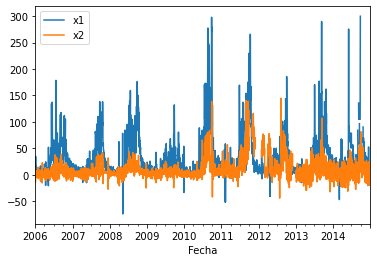

In [140]:
x1 = data[data['nombre'] == 'x1']
x1.index = x1['Fecha']
x1 = x1[['data']]
x1.columns = ['value']
x1_s = pd.Series(data=x1['value'], index=x1.index)

x2 = data[data['nombre'] == 'x2']
x2.index = x2['Fecha']
x2 = x2[['data']]
x2.columns = ['value']
x2_s = pd.Series(data=x2['value'], index=x2.index)

x1_s.plot()
x2_s.plot()
plt.legend(['x1', 'x2'])
plt.show()

### Sustituir los datos faltantes por variables.
- ¿Cuantos valores faltantes hay en cada variable?
- ¿Cuantos fechas faltantes diarias hay en cada variable?
- ¿Cuantas fechas diferentes hay entre la variable 1 y la variable 2?

In [141]:
x1_s.isna().sum(), x2_s.isna().sum()

(85, 124)

Como sabemos que es una serie temporal, y parece haber valores faltantes en un periodos consecutivos, creo que la mejor opción es hacer una interpolación. Hay muchas formas de hacerlo pero la más sencilla es por medio *lineal*.
Cuando encontremos un valor faltante entonces calculamos la pendiente entre $ x_{t} $ y $ x_{\Delta t} $, como si trazaramos una linea recta entre dichos puntos y el valor de dicha recta en $t+1$ sera el nuevo valor.

En las fechas no estamos seguros de que haya faltantes diarios, pero para asegurarnos de tener todos los días vamos a generar un nuevo indice con el mínimo y máximo antés de interpolar.

![interpolate](https://pandas.pydata.org/pandas-docs/version/0.7.0/_images/series_interpolate.png)

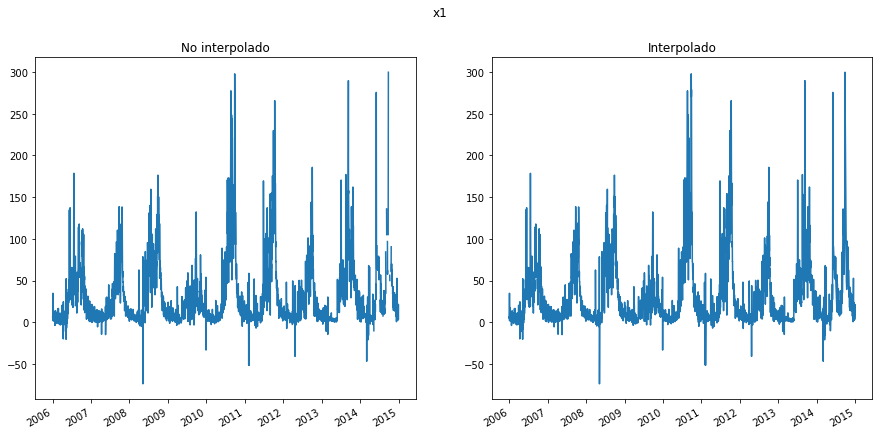

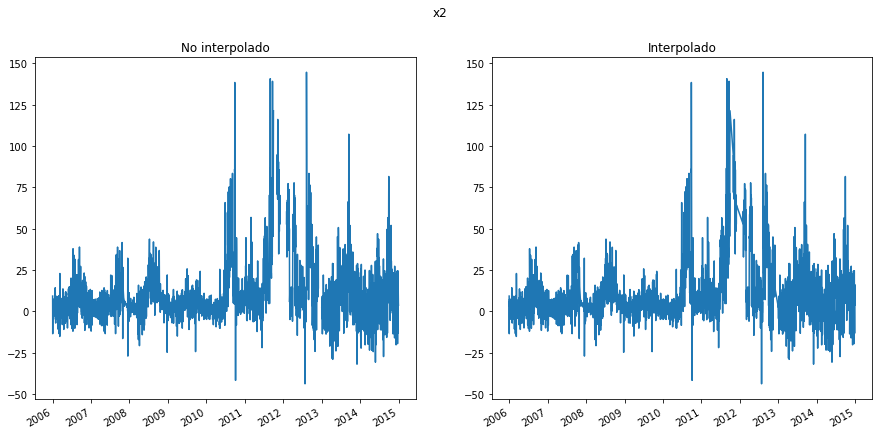

In [142]:
x1_s = x1_s.reindex(pd.date_range(start=x1_s.index.min(),
                                end=x1_s.index.max(),
                                freq='1D'))
x1_s.interpolate(method='linear', inplace=True)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
ax1.plot(x1)
ax1.set(title='No interpolado')
ax2.plot(x1_s)
ax2.set(title='Interpolado')
fig.autofmt_xdate()
fig.suptitle('x1')
plt.show()

x2_s = x2_s.reindex(pd.date_range(start=x2_s.index.min(),
                                end=x2_s.index.max(),
                                freq='1D'))
x2_s.interpolate(method='linear', inplace=True)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
ax1.plot(x2)
ax1.set(title='No interpolado')
ax2.plot(x2_s)
ax2.set(title='Interpolado')
fig.autofmt_xdate()
fig.suptitle('x2')
plt.show()

Ahora nos aseguramos que no haya faltantes y las fechas coinciden.

In [143]:
x1_s.isna().sum(), x2_s.isna().sum()

(0, 0)

In [144]:
len(x1_s.index), len(x2_s.index)

(3287, 3287)

In [145]:
x1_s.index.min(), x2_s.index.min()

(Timestamp('2006-01-01 00:00:00', freq='D'),
 Timestamp('2006-01-01 00:00:00', freq='D'))

In [146]:
x1_s.index.max(), x2_s.index.max()

(Timestamp('2014-12-31 00:00:00', freq='D'),
 Timestamp('2014-12-31 00:00:00', freq='D'))

### Transformar ambas variables para acercarlas a una distribución normal usando Yeo-Johnson

- Gráficar histogramas y calcular el sesgo.
- Transformar usando Yeo-Johnson y el lambda optimo usando la función de *scipy*. La función tambien proporciona el lambda que maximiza la función log-likelihood.
- Probar la normalidad.

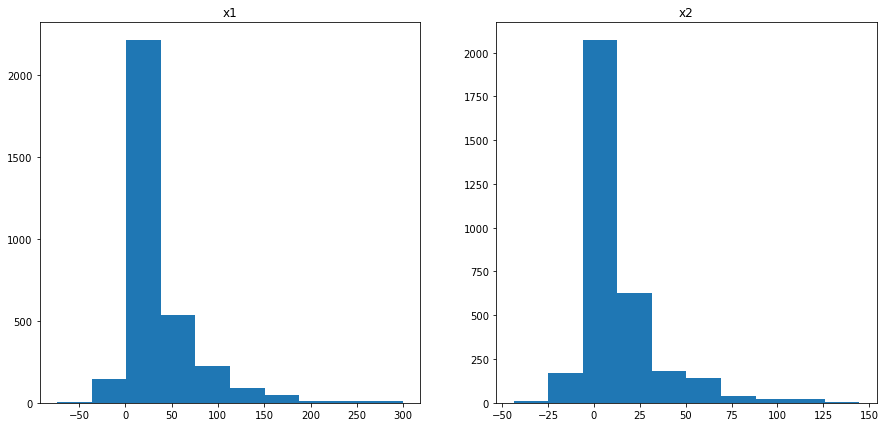

In [147]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
ax1.hist(x1_s)
ax1.set(title='x1')
ax2.hist(x2_s)
ax2.set(title='x2')
plt.show()

In [148]:
x1_s.skew(), x2_s.skew()

(2.317259496113994, 2.327223918717074)

Ambas variables tienen histograma y sesgo muy similares. Ambas son leptocúrtica y sesgadas a las derecha con sesgo positivo pero la primera parece tener más atípicos.

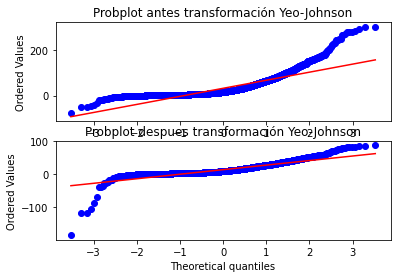

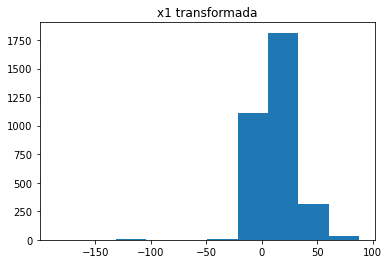

el sesgo de x1 después de la tranformación es -0.15150169702651153


In [149]:
x1_yj, x1_maxlog = stats.yeojohnson(x1_s)

fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(x1_s, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot antes transformación Yeo-Johnson')
ax2 = fig.add_subplot(212)
prob = stats.probplot(x1_yj, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot despues transformación Yeo-Johnson')
plt.show()

plt.hist(x1_yj)
plt.title('x1 transformada')
plt.show()
print('el sesgo de x1 después de la tranformación es ' + str(pd.DataFrame(x1_yj).skew()[0]))

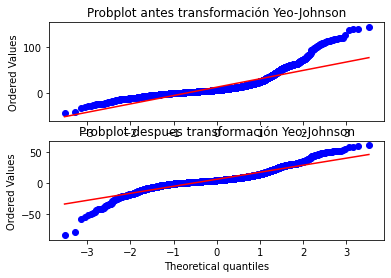

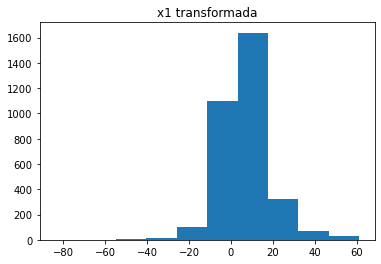

el sesgo de x2 después de la tranformación es 0.21528531866049072


In [150]:
x2_yj, x2_maxlog = stats.yeojohnson(x2_s)

fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(x2_s, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot antes transformación Yeo-Johnson')
ax2 = fig.add_subplot(212)
prob = stats.probplot(x2_yj, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot despues transformación Yeo-Johnson')
plt.show()

plt.hist(x2_yj)
plt.title('x1 transformada')
plt.show()
print('el sesgo de x2 después de la tranformación es ' + str(pd.DataFrame(x2_yj).skew()[0]))

La tranformación Yeo Johnson due bastante útil ya que el sesgo disminuyo dos unidades para ambas variables, y la normalidad mejoro también.

In [151]:
x1_s = pd.Series(data=x1_yj, index=x1_s.index)
x2_s = pd.Series(data=x2_yj, index=x2_s.index)

### Identificar datos extremos y sustituirlos de ser el caso.

Usando la regla de 3 el rango intercuartilico antes y despues el rango intercuartilico.

In [152]:
x1_q1 = x1_s.quantile(0.25)
x1_q3 = x1_s.quantile(0.75)
x1_iqr = x1_q3 - x1_q1
print('Variable x1 tiene ' + str(((x1_s < x1_q1-3*x1_iqr)|(x1_s > x1_q3+3*x1_iqr)).sum()) + ' valores extremos.')

x2_q1 = x2_s.quantile(0.25)
x2_q3 = x2_s.quantile(0.75)
x2_iqr = x2_q3 - x2_q1
print('Variable x2 tiene ' + str(((x2_s < x2_q1-3*x2_iqr)|(x2_s > x2_q3+3*x2_iqr)).sum()) + ' valores extremos.')

Variable x1 tiene 24 valores extremos.
Variable x2 tiene 89 valores extremos.


Por la naturaleza de la los datos puede que estas mediciones atípicas sean días de mucha lluvía. Una buena forma de tratarlos sería como una variable codificada que para todos estos valores 1 y 0 todos los que no. La variable serviria para el modelo de regresión.

Una forma más fácil es sustituirlos por 1.5 veces el rango intercuartilico por que eso mantendría la dirección y magnitud de la observación.

In [153]:
x1_s[(x1_s < x1_q1-3*x1_iqr) | (x1_s > x1_q3+3*x1_iqr)]

2008-05-08   -186.253129
2009-12-29    -68.853468
2010-08-21     75.946428
2010-08-22     83.016240
2010-08-23     75.303677
2010-08-28     76.520955
2010-08-30     75.590862
2010-09-27     87.491144
2010-09-28     81.463657
2010-09-29     83.320183
2011-02-07   -117.848571
2011-02-10   -118.972617
2011-09-30     72.181158
2011-10-12     80.392741
2012-04-22    -88.879330
2013-09-10     71.938256
2013-09-11     85.704692
2014-03-04   -105.100472
2014-06-03     82.598500
2014-09-26     87.909065
2014-09-27     83.802159
2014-09-28     79.621637
2014-09-29     75.360792
2014-09-30     71.011734
dtype: float64

In [154]:
x1_s[x1_s < x1_q1-3*x1_iqr] = x1_q1 - 1.5*x1_iqr
x1_s[x1_s > x1_q3+3*x1_iqr] = x1_q3 + 1.5*x1_iqr

In [155]:
x2_s[(x2_s < x2_q1-3*x2_iqr) | (x2_s > x2_q3+3*x2_iqr)]

2007-12-17   -47.104739
2008-03-26   -27.208112
2008-04-05   -34.344603
2008-12-24   -42.364824
2009-09-20   -41.549698
                ...    
2014-08-04   -27.397074
2014-08-11   -47.729448
2014-09-30    38.876992
2014-12-08   -33.363501
2014-12-22   -31.998454
Length: 89, dtype: float64

In [156]:
x2_s[x2_s < x2_q1-3*x2_iqr] = x2_q1 - 1.5*x2_iqr
x2_s[x2_s > x2_q3+3*x2_iqr] = x2_q3 + 1.5*x2_iqr

### Discretizar las variables de acuerdo a la acumulación de datos usando k-means.

La razón de usar dos grupos es que uno captura el temporal de lluvia y el otro es la base.

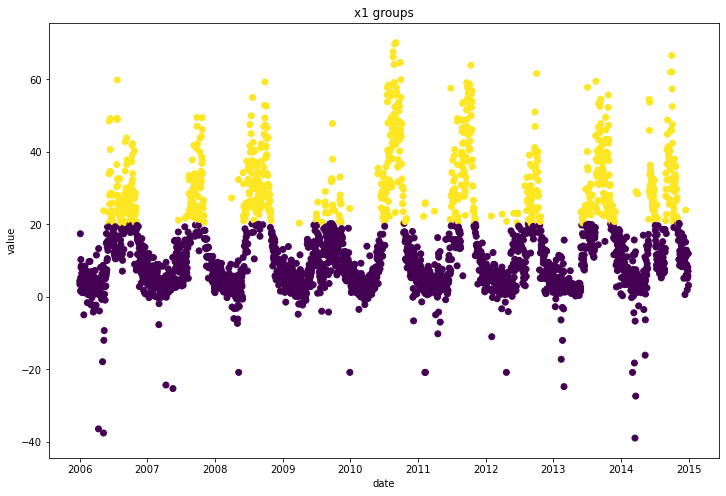

In [157]:
K = 2
kmeans_disc = KBinsDiscretizer(n_bins=K ,encode='ordinal', strategy='kmeans')
x1_groups = kmeans_disc.fit_transform(x1_s.values.reshape(-1,1))

plt.figure(figsize=(12,8))
plt.scatter(y=x1_s, x=x1_s.index, c=x1_groups)
plt.title('x1 groups')
plt.xlabel('date')
plt.ylabel('value')
plt.show()

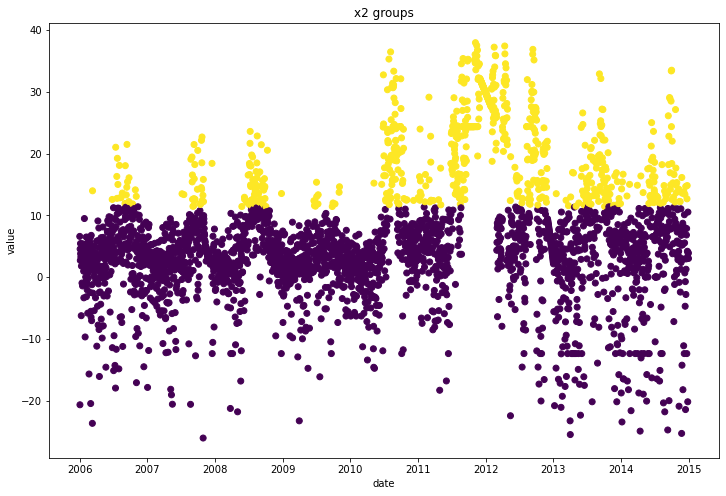

In [158]:
K = 2
kmeans_disc = KBinsDiscretizer(n_bins=K ,encode='ordinal', strategy='kmeans')
x2_groups = kmeans_disc.fit_transform(x2_s.values.reshape(-1,1))

plt.figure(figsize=(12,8))
plt.scatter(y=x2_s, x=x2_s.index, c=x2_groups)
plt.title('x2 groups')
plt.xlabel('date')
plt.ylabel('value')
plt.show()

### Extraer la media, desviación estándar y tendencia de cada grupo para las variables x1 y x2.

Primero tenermos que calcular el time stamp en cada periodo de tiempo. Y después tenemos que elegir la ventana w.
Las caracteristicas de cada ventana nos ayudaran a hacer mejores estimaciones.

In [159]:
segs = x1_s.index.map(datetime.datetime.timestamp)
segs = segs.to_numpy()

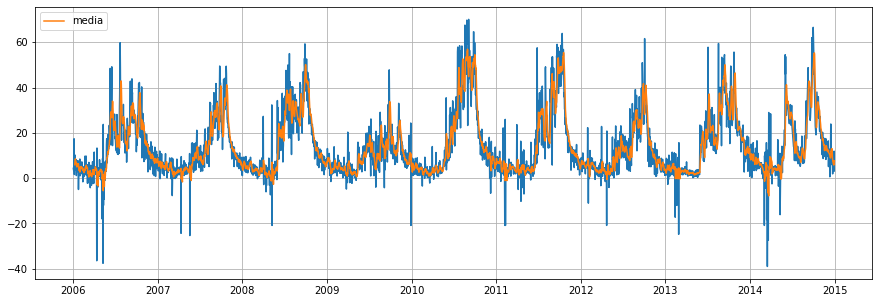

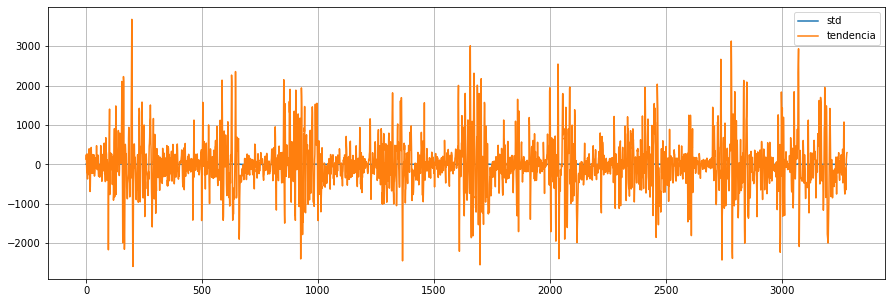

In [160]:
x = x1_s
x1_me=[]
x1_std=[]
x1_tendencia=[]
w = 6
lin = LinearRegression()
for i in range(len(x)-w):
    x1_me.append(x[i:i+w].mean())
    x1_std.append(x[i:i+w].std())
    t = segs[i:i+w]/(60*60*24*365.2425)
    lin.fit(t.reshape(-1,1), x[i:i+w])
    x1_tendencia.append(lin.coef_[0])

plt.figure(figsize=(15,5))
plt.plot(x)
plt.plot(x1_s.index[w:],x1_me,label='media')
plt.legend()
plt.grid()

plt.figure(figsize=(15,5))
plt.plot(x1_std,label='std')
plt.plot(x1_tendencia,label='tendencia')
plt.legend()
plt.grid()


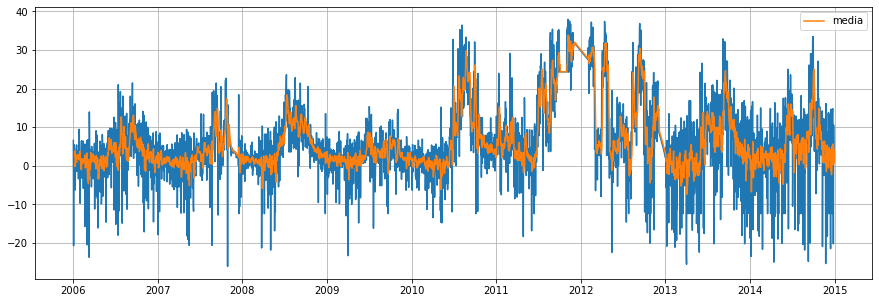

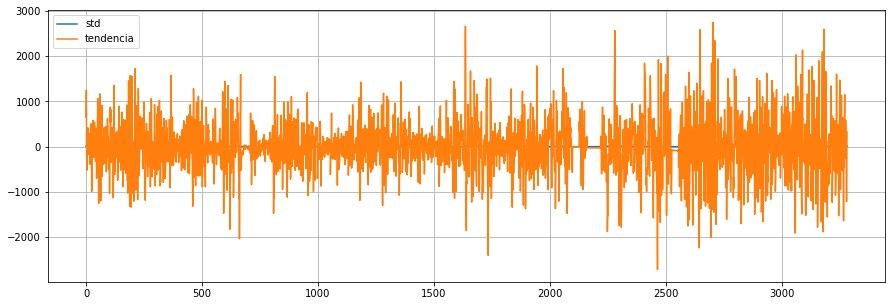

In [161]:
x = x2_s
x2_me=[]
x2_std=[]
x2_tendencia=[]
w = 6
lin = LinearRegression()
for i in range(len(x)-w):
    x2_me.append(x[i:i+w].mean())
    x2_std.append(x[i:i+w].std())
    t = segs[i:i+w]/(60*60*24*365.2425)
    lin.fit(t.reshape(-1,1), x[i:i+w])
    x2_tendencia.append(lin.coef_[0])

plt.figure(figsize=(15,5))
plt.plot(x)
plt.plot(x2_s.index[w:],x2_me,label='media')
plt.legend()
plt.grid()

plt.figure(figsize=(15,5))
plt.plot(x2_std,label='std')
plt.plot(x2_tendencia,label='tendencia')
plt.legend()
plt.grid()


### Transformar ahora las características extraídas usando Yeo-Johnson.

In [162]:
x1_me, _ = stats.yeojohnson(x1_me)
x1_std, _ = stats.yeojohnson(x1_std)
x1_tendencia, _ = stats.yeojohnson(x1_tendencia)
x2_me, _ = stats.yeojohnson(x2_me)
x2_std, _ = stats.yeojohnson(x2_std)
x2_tendencia, _ = stats.yeojohnson(x2_tendencia)

Une las *series* a un *dataframe* del mismo tamaño

In [164]:
x1 = pd.DataFrame(data=x1_s.values[w:], index=x1_s.index[w:], columns=['y'])
x1['groups'] = x1_groups[w:]
x1['me'] = x1_me
x1['std'] = x1_std
x1['tendencia'] = x1_tendencia

x2 = pd.DataFrame(data=x2_s.values[w:], index=x2_s.index[w:], columns=['y'])
x2['groups'] = x2_groups[w:]
x2['me'] = x2_me
x2['std'] = x2_std
x2['tendencia'] = x2_tendencia

### Escalar las características transformadas de acuerdo a su criterio.

La estandarización de un conjunto de datos es un requisito común para muchos estimadores de aprendizaje automático: es posible que se comporten mal si las características individuales no se parecen más o menos a los datos estándar distribuidos normalmente.
Por ejemplo, muchos elementos utilizados en la función objetivo de un algoritmo de aprendizaje (como el kernel RBF de Support Vector Machines o L1 y L2 regularizadores de modelos lineales) asumen que todas las características están centradas alrededor de 0 y tienen varianza en el mismo orden.

### Escalar los grupos de cada variable de x1 y x2 para que se ajuste al dominio de la función de activación que escoja.

La función de salida de los datos debe estar entre -1 y 1 como la funcion tanh.

In [165]:
scaler = MinMaxScaler((-1,1))
cthr_cols = ['me', 'std', 'tendencia']
cols = ['fecha', 'me', 'std', 'tendencia', 'groups', 'y']

for i in range(K):
    #selecciona el grupo
    group = x1[x1['groups'] == i]
    #escala el grupo
    group_sc_x = zscore(group[cthr_cols].values)
    group_sc_y = scaler.fit_transform(group['y'].values.reshape(-1, 1))
    #append the date to keep the order if needed
    group_sc = np.column_stack([list(group.index.to_native_types()), group_sc_x, group['groups'], group_sc_y])
    #append to others grops
    if i == 0:
        x1_scl = group_sc
    else:
        x1_scl = np.row_stack([x1_scl, group_sc])

x1 = pd.DataFrame(data=x1_scl, columns=cols)


for i in range(K):
    #selecciona el grupo
    group = x2[x2['groups'] == i]
    #escala el grupo
    group_sc_x = zscore(group[cthr_cols].values)
    group_sc_y = scaler.fit_transform(group['y'].values.reshape(-1, 1))
    #append the date to keep the order if needed
    group_sc = np.column_stack([list(group.index.to_native_types()), group_sc_x, group['groups'], group_sc_y])
    #append to others grops
    if i == 0:
        x2_scl = group_sc
    else:
        x2_scl = np.row_stack([x2_scl, group_sc])

x2 = pd.DataFrame(data=x2_scl, columns=cols)

C:\Users\nuno\AppData\Local\Temp\ipykernel_23700\2004230766.py:12: FutureWarning: The 'to_native_types' method is deprecated and will be removed in a future version. Use 'astype(str)' instead.
  group_sc = np.column_stack([list(group.index.to_native_types()), group_sc_x, group['groups'], group_sc_y])
C:\Users\nuno\AppData\Local\Temp\ipykernel_23700\2004230766.py:12: FutureWarning: The 'to_native_types' method is deprecated and will be removed in a future version. Use 'astype(str)' instead.
  group_sc = np.column_stack([list(group.index.to_native_types()), group_sc_x, group['groups'], group_sc_y])
C:\Users\nuno\AppData\Local\Temp\ipykernel_23700\2004230766.py:29: FutureWarning: The 'to_native_types' method is deprecated and will be removed in a future version. Use 'astype(str)' instead.
  group_sc = np.column_stack([list(group.index.to_native_types()), group_sc_x, group['groups'], group_sc_y])
C:\Users\nuno\AppData\Local\Temp\ipykernel_23700\2004230766.py:29: FutureWarning: The 'to_nati

In [166]:
group_sc_x.shape, group_sc_y.shape, group.index.shape, group['groups'].shape, group_sc.shape, x1_scl.shape

((751, 3), (751, 1), (751,), (751,), (751, 6), (3281, 6))

### Definir y entrenar una red neuronal para cada grupo de x1 y x2.

In [2]:
y = x1[x1['groups'] == 1]['y'].as
X = x1[x1['groups'] == 1][['me', 'std', 'tendencia']]

NameError: name 'x1' is not defined

### Definir una segunda red neuronal cuyas entradas sean las salidas de las redes neuronales de cada grupo en x1 y la salida sea la serie x1. Repetir para la variable x2.